# Forecast Model Comparison 

Source DL models: https://pure.tudelft.nl/ws/portalfiles/portal/43646098/1_s2.0_S030626191830196X_main.pdf

## 1. Load Data

In [44]:
import sqlite3
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Connect to the SQLite database (if the database doesn't exist, it will be created)
conn = sqlite3.connect('Main_DB')

# Create a cursor object to interact with the database
cursor = conn.cursor()

# Your SQL query
temp_df = '''
SELECT * from wind
'''

# Read SQL query result into a DataFrame
wind = pd.read_sql_query(temp_df, conn)
wind.rename(columns={'value': 'wind_generation'}, inplace=True)

# Your SQL query
temp_df = '''
SELECT * from spot_price
'''

# Read SQL query result into a DataFrame
spot_price = pd.read_sql_query(temp_df, conn)

# Read SQL query result into a DataFrame
spot_price = pd.read_sql_query(temp_df, conn)
spot_price.rename(columns={'value': 'spot_price'}, inplace=True)

# Your SQL query
temp_df = '''
SELECT * from solar
'''

# Read SQL query result into a DataFrame
solar = pd.read_sql_query(temp_df, conn)
solar.rename(columns={'value': 'solar_generation'}, inplace=True)

# Your SQL query
temp_df = '''
SELECT * from demand
'''

# Read SQL query result into a DataFrame
demand = pd.read_sql_query(temp_df, conn)
demand.rename(columns={'value': 'demand'}, inplace=True)

# Your SQL query
temp_df = '''
SELECT * from nuclear
'''

# Read SQL query result into a DataFrame
nuclear = pd.read_sql_query(temp_df, conn)
nuclear.rename(columns={'value': 'nuclear_generation'}, inplace=True)

# SQL query
temp_df = '''
SELECT * from gas_data
'''

# Read SQL query result into a DataFrame
gas_data = pd.read_sql_query(temp_df, conn)
gas_data.rename(columns={'value': 'gas_price'}, inplace=True)
gas_data_hourly = gas_data.reindex(gas_data.index.repeat(24)).reset_index(drop=True)

# Close the connection
conn.close()

# Display the DataFrame


Create original df

In [45]:
df=wind.merge(spot_price, left_on=['day', 'hour'], right_on=['day', 'hour']) \
        .merge(solar, left_on=['day', 'hour'], right_on=['day', 'hour']) \
        .merge(demand, left_on=['day', 'hour'], right_on=['day', 'hour']) \
        .merge(nuclear, left_on=['day', 'hour'], right_on=['day', 'hour']) \
        .merge(gas_data, left_on=['day'], right_on=['delivery_day'])\
        .drop('delivery_day', axis=1)

df.head(5)

,wind_generation,day,hour,spot_price,solar_generation,demand,nuclear_generation,index_price
0,3214.0,2019-01-01,01:00,66.88,0.0,23753.0,6071.9,24.45
1,3222.0,2019-01-01,02:00,66.88,0.0,23018.0,6071.9,24.45
2,3081.0,2019-01-01,03:00,66.00,0.0,21808.0,6071.9,24.45
3,3069.0,2019-01-01,04:00,63.64,0.0,20635.0,6071.9,24.45
4,2973.0,2019-01-01,05:00,58.85,0.0,19824.0,6071.9,24.45


In [46]:
low_bidding_price = ['solar_generation', 'wind_generation', 'nuclear_generation']
renewable = ['solar_generation', 'wind_generation']

# Create a new column based on the condition
df['covered_renewables'] = (df[renewable].sum(axis=1) > df['demand']).astype(int)
df['covered_low_price'] = (df[low_bidding_price].sum(axis=1) > df['demand']).astype(int)

df = df.dropna()


In [47]:
X = df[['wind_generation', 'solar_generation', 'demand', 'index_price', 'nuclear_generation', 'covered_renewables', 'covered_low_price']]
y = df['spot_price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


In [48]:
def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

In [49]:
df.to_csv('market_data.csv', header=True, index=None, sep=' ', mode='a')


In [50]:
results = pd.DataFrame()

## 1. Linear Regression

In [51]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt


reg = LinearRegression().fit(X_train, y_train)
pred_reg = reg.predict(X_test)

In [52]:
# Calculate MSE and MAE
mse_lr = mean_squared_error(y_test, pred_reg)
mae_lr = mean_absolute_error(y_test, pred_reg)

# New row to be added
lr_results = {'model': 'Linear Regression', 'MSE': mse_lr, 'MAE': mae_lr}

# Specify the new row directly
results = results.append(lr_results, ignore_index=True)
results

C:\Users\ubeda\AppData\Local\Temp\ipykernel_3280\396656799.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(lr_results, ignore_index=True)


,model,MSE,MAE
0,Linear Regression,1369.261214,26.414516


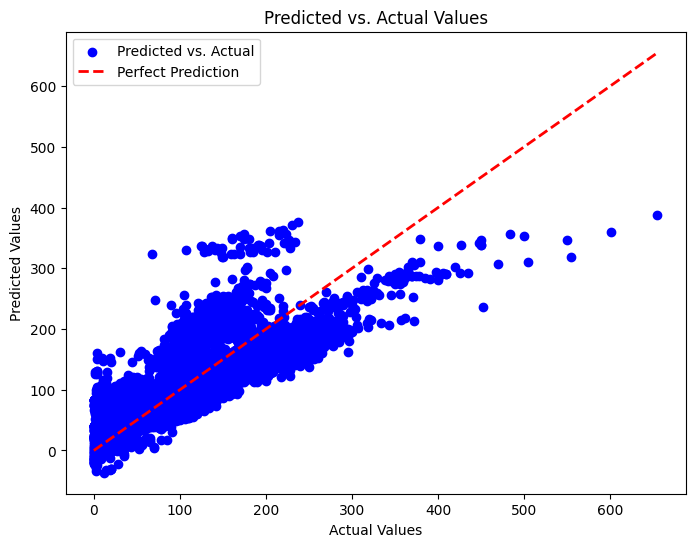

In [20]:
# Plotting the predicted values vs. actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, pred_reg, color='blue', label='Predicted vs. Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. Actual Values')
plt.legend()
plt.show()


## 2. CART

In [22]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

regressor = DecisionTreeRegressor(random_state=42, min_samples_split=50)
regressor.fit(X_train, y_train)

# Predict on the test set
pred_CART = regressor.predict(X_test)



Mean Squared Error: 422.94212714288386


In [53]:
# Calculate MSE and MAE
mse_CART = mean_squared_error(y_test, pred_CART)
mae_CART = mean_absolute_error(y_test, pred_CART)

# New row to be added
CART_results = {'model': 'CART', 'MSE': mse_CART, 'MAE': mae_CART}

# Specify the new row directly
results = results.append(CART_results, ignore_index=True)
results

C:\Users\ubeda\AppData\Local\Temp\ipykernel_3280\2462508764.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(CART_results, ignore_index=True)


,model,MSE,MAE
0,Linear Regression,1369.261214,26.414516
1,CART,422.942127,11.142663


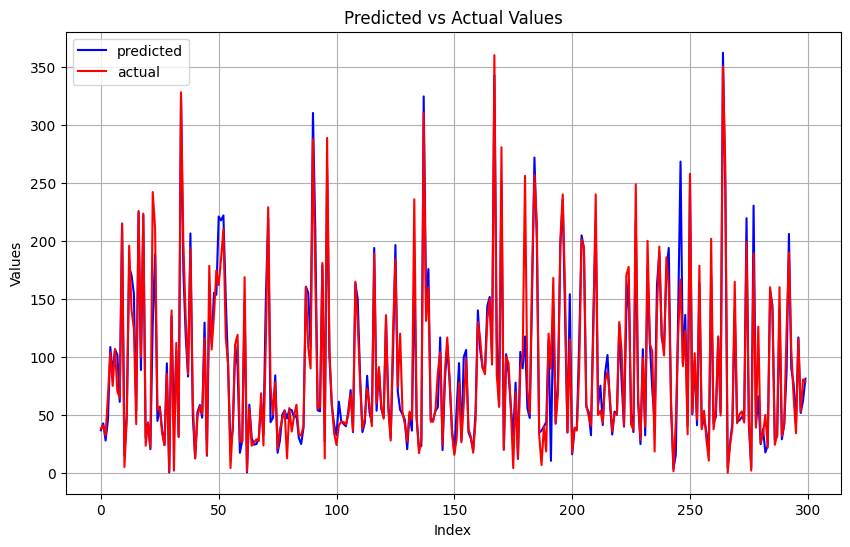

In [24]:
# Extracting 'Predicted' and 'Actual' columns from the DataFrame for the first 100 hours
predicted_values = df_comparison['Predicted'].iloc[:300]  # Selecting first 100 values
actual_values = df_comparison['Actual'].iloc[:300]  # Selecting first 100 values

# Creating a scatter plot for the first 100 hours
plt.figure(figsize=(10, 6))


# Connecting the dots with lines
plt.plot(range(len(predicted_values)), predicted_values, label='predicted', color='blue')  # Line connecting 'Predicted' values
plt.plot(range(len(actual_values)), actual_values, label='actual', color='red')  # Line connecting 'Actual' values

plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Predicted vs Actual Values')
plt.legend()
plt.grid(True)
plt.show()


## 3. XGBOOST

In [25]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

# Generate synthetic regression data
X, y = make_regression(n_samples=1000, n_features=10, noise=0.1, random_state=42)

# Define XGBoost regressor
reg = xgb.XGBRegressor()

# Define the hyperparameter grid to search
param_grid = {
    'n_estimators': [100, 500, 1000],  
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(estimator=reg, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X, y)

# Get the best parameters and best estimator
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

print("Best Parameters:", best_params)



Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 1000, 'subsample': 0.8}


In [26]:
reg_best_parameters = xgb.XGBRegressor(colsample_bytree = best_params['colsample_bytree'],\
                                       learning_rate = best_params['learning_rate'],\
                                       max_depth = best_params['max_depth'],\
                                       n_estimators = best_params['n_estimators'],\
                                       subsample = best_params['subsample'])

In [27]:
xg_model = reg_best_parameters.fit(X_train, y_train)

pred_xgboost = xg_model.predict(X_test)

10.724308158651947

In [55]:
# Calculate MSE and MAE
mse_XG = mean_squared_error(y_test, pred_xgboost)
mae_XG = mean_absolute_error(y_test, pred_xgboost)

# New row to be added
XG_results = {'model': 'XGBoost', 'MSE': mse_XG, 'MAE': mae_XG}

# Specify the new row directly
results = results.append(XG_results, ignore_index=True)
results

C:\Users\ubeda\AppData\Local\Temp\ipykernel_3280\815242773.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(XG_results, ignore_index=True)


,model,MSE,MAE
0,Linear Regression,1369.261214,26.414516
1,CART,422.942127,11.142663
2,CART,337.675163,10.724308
3,XGBoost,337.675163,10.724308


In [66]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import make_regression
from scipy.stats import uniform

# Generate synthetic regression data
X, y = make_regression(n_samples=1000, n_features=10, noise=0.1, random_state=42)

# Define AdaBoost regressor with DecisionTreeRegressor as the base estimator
reg = AdaBoostRegressor(base_estimator=DecisionTreeRegressor())

# Define the hyperparameter distributions to search
param_dist = {
    'n_estimators': [50, 100, 200, 300],  
    'learning_rate': uniform(0.01, 0.2 - 0.01),  
    'loss': ['linear', 'square', 'exponential'],  
    'base_estimator__max_depth': [1, 2, 3],  # Decision tree depth
    'base_estimator__min_samples_split': [2, 5, 10],  # Minimum samples required to split
    'base_estimator__min_samples_leaf': [1, 2, 4],  # Minimum samples required at each leaf node
}

# Perform Randomized Search with cross-validation
random_search = RandomizedSearchCV(estimator=reg, param_distributions=param_dist, n_iter=20, cv=5, scoring='neg_mean_squared_error', random_state=42)
random_search.fit(X_train, y_train)

# Get the best parameters and best estimator
best_params = random_search.best_params_
best_estimator = random_search.best_estimator_

print("Best Parameters:", best_params)

# Optionally, you can evaluate the performance of the best estimator on your data
# For example:
# predictions = best_estimator.predict(X)
# mse = mean_squared_error(y, predictions)
# print("Mean Squared Error:", mse)


C:\Users\ubeda\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\ubeda\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\ubeda\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\ubeda\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\ubeda\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` 

Best Parameters: {'base_estimator__max_depth': 3, 'base_estimator__min_samples_leaf': 2, 'base_estimator__min_samples_split': 10, 'learning_rate': 0.028995234005420548, 'loss': 'exponential', 'n_estimators': 300}


In [68]:
pred_ADA = best_estimator.predict(X_test)

In [69]:
# Calculate MSE and MAE
mse_ADA = mean_squared_error(y_test, pred_ADA)
mae_ADA = mean_absolute_error(y_test, pred_ADA)

# New row to be added
ADA_results = {'model': 'ADABoost', 'MSE': mse_ADA, 'MAE': mae_ADA}

# Specify the new row directly
results = results.append(ADA_results, ignore_index=True)
results

C:\Users\ubeda\AppData\Local\Temp\ipykernel_3280\1697947124.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(ADA_results, ignore_index=True)


,model,MSE,MAE
0,Linear Regression,1369.261214,26.414516
1,CART,422.942127,11.142663
2,CART,337.675163,10.724308
3,XGBoost,337.675163,10.724308
4,ADABoost,1402.702025,29.121955
5,ADABoost,1151.698588,22.856649


# 4. DNN

In [70]:
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from scikeras.wrappers import KerasRegressor
import tensorflow as tf

# Define the parameters grid
params = {
    'batch_size': [20, 25],
    'epochs': [50, 70],
    'model__neurons_1': [6, 7],
    'model__neurons_2': [4, 3],
    'model__activation': ['relu', 'softmax'],
    'model__optimizer': ['adam', 'rmsprop'],
    'model__dropout': [0.1, 0.2]
}


# Function to create the neural network model
def create_model(neurons_1, neurons_2, activation, optimizer, dropout):
    nn = tf.keras.Sequential()
    nn.add(tf.keras.layers.Input(shape=(X_train.shape[1],)))  # Adjusted input shape here
    nn.add(tf.keras.layers.Dense(units=neurons_1,
                                  activation=activation,
                                  kernel_initializer='glorot_uniform'))
    nn.add(tf.keras.layers.Dropout(rate=dropout))
    nn.add(tf.keras.layers.Dense(units=neurons_2, activation=activation))
    nn.add(tf.keras.layers.Dropout(rate=dropout))
    nn.add(tf.keras.layers.Dense(units=1, activation='linear'))
    nn.compile(optimizer=optimizer,
               loss='mean_absolute_error',
               metrics=['mean_absolute_error']) 
    return nn

# Create KerasRegressor
model = KerasRegressor(model=create_model)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define additional parameters for fitting the model
fit_params = {
    'callbacks': [tf.keras.callbacks.EarlyStopping(patience=3)],  # Add early stopping callback
    'verbose': 1  # Set verbosity to 1 for progress bar
}

# Perform grid search with fit_params
gs = GridSearchCV(estimator=model, param_grid=params, scoring='accuracy', cv=10,
                  n_jobs=-1, return_train_score=True, verbose=0)
grid_result = gs.fit(X_train, y_train, **fit_params)

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# Evaluate best model on test set
best_model = grid_result.best_estimator_
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Test MSE:", mse)


KeyboardInterrupt: 

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from scikeras.wrappers import KerasRegressor
import tensorflow as tf

# Define the parameters grid
params = {
    'batch_size': 20,
}

# Function to create the neural network model
def create_model():
    nn = tf.keras.Sequential()
    nn.add(tf.keras.layers.Input(shape=(X_train.shape[1],)))  # Adjusted input shape here
    nn.add(tf.keras.layers.Dense(units=6, activation='relu', kernel_initializer='glorot_uniform'))
    nn.add(tf.keras.layers.Dropout(rate=0.1))
    nn.add(tf.keras.layers.Dense(units=4, activation='relu'))
    nn.add(tf.keras.layers.Dropout(rate=0.1))
    nn.add(tf.keras.layers.Dense(units=1, activation='linear'))
    nn.compile(optimizer='adam',
               loss='mean_squared_error')  # Use mean squared error for regression
    return nn

# Create KerasRegressor
model = KerasRegressor(model=create_model)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
model.fit(X_train, y_train, epochs=50, callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)], verbose=1)

# Evaluate the model on test set
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Test MSE:", mse)


Epoch 1/50
1102/1102 [==============================] - 1s 839us/step - loss: 260361.5000
Epoch 2/50
1102/1102 [==============================] - 1s 828us/step - loss: 13636.1074
Epoch 3/50
1102/1102 [==============================] - 1s 846us/step - loss: 8236.9561
Epoch 4/50
1102/1102 [==============================] - 1s 854us/step - loss: 6944.7725
Epoch 5/50
1102/1102 [==============================] - 1s 844us/step - loss: 6530.1406
Epoch 6/50
1102/1102 [==============================] - 1s 836us/step - loss: 6321.0586
Epoch 7/50
1102/1102 [==============================] - 1s 844us/step - loss: 6061.7012
Epoch 8/50
1102/1102 [==============================] - 1s 837us/step - loss: 5987.1333
Epoch 9/50
1102/1102 [==============================] - 1s 847us/step - loss: 5685.5298
Epoch 10/50
1102/1102 [==============================] - 1s 833us/step - loss: 4898.0352
Epoch 11/50
1102/1102 [==============================] - 1s 840us/step - loss: 3137.5027
Epoch 12/50
1102/1102 [====

In [ ]:
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from scikeras.wrappers import KerasRegressor
import tensorflow as tf

# Define the parameters grid
params = {
    'batch_size': [20, 25],
    'epochs': [50, 70],
    'model__neurons_1': [6, 7],
    'model__neurons_2': [4, 3],
    'model__activation': ['relu', 'softmax'],
    'model__optimizer': ['adam', 'rmsprop'],
    'model__dropout': [0.1, 0.2]
}


# Function to create the neural network model
def create_model(neurons_1, neurons_2, activation, optimizer, dropout):
    nn = tf.keras.Sequential()
    nn.add(tf.keras.layers.Input(shape=(X_train.shape[1],)))  # Adjusted input shape here
    nn.add(tf.keras.layers.Dense(units=neurons_1,
                                  activation=activation,
                                  kernel_initializer='glorot_uniform'))
    nn.add(tf.keras.layers.Dropout(rate=dropout))
    nn.add(tf.keras.layers.Dense(units=neurons_2, activation=activation))
    nn.add(tf.keras.layers.Dropout(rate=dropout))
    nn.add(tf.keras.layers.Dense(units=1, activation='linear'))
    nn.compile(optimizer=optimizer,
               loss='mean_absolute_error',
               metrics=['mean_absolute_error']) 
    return nn

# Create KerasRegressor
model = KerasRegressor(model=create_model)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define additional parameters for fitting the model
fit_params = {
    'callbacks': [tf.keras.callbacks.EarlyStopping(patience=3)],  # Add early stopping callback
    'verbose': 1  # Set verbosity to 1 for progress bar
}

# Perform grid search with fit_params
gs = GridSearchCV(estimator=model, param_grid=params, scoring='accuracy', cv=10,
                  n_jobs=-1, return_train_score=True, verbose=0)
grid_result = gs.fit(X_train, y_train, **fit_params)

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# Evaluate best model on test set
best_model = grid_result.best_estimator_
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Test MSE:", mse)


KeyboardInterrupt: 

In [ ]:
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from scikeras.wrappers import KerasRegressor
import tensorflow as tf

# Define the parameters grid
params = {
    'batch_size': [20, 25],
    'epochs': [50, 70],
    'model__neurons_1': [6, 7],
    'model__neurons_2': [4, 3],
    'model__activation': ['relu', 'softmax'],
    'model__optimizer': ['adam', 'rmsprop'],
    'model__dropout': [0.1, 0.2]
}


# Function to create the neural network model
def create_model(neurons_1, neurons_2, activation, optimizer, dropout):
    nn = tf.keras.Sequential()
    nn.add(tf.keras.layers.Input(shape=(X_train.shape[1],)))  # Adjusted input shape here
    nn.add(tf.keras.layers.Dense(units=neurons_1,
                                  activation=activation,
                                  kernel_initializer='glorot_uniform'))
    nn.add(tf.keras.layers.Dropout(rate=dropout))
    nn.add(tf.keras.layers.Dense(units=neurons_2, activation=activation))
    nn.add(tf.keras.layers.Dropout(rate=dropout))
    nn.add(tf.keras.layers.Dense(units=1, activation='linear'))
    nn.compile(optimizer=optimizer,
               loss='mean_absolute_error',
               metrics=['mean_absolute_error']) 
    return nn

# Create KerasRegressor
model = KerasRegressor(model=create_model)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define additional parameters for fitting the model
fit_params = {
    'callbacks': [tf.keras.callbacks.EarlyStopping(patience=3)],  # Add early stopping callback
    'verbose': 1  # Set verbosity to 1 for progress bar
}

# Perform grid search with fit_params
gs = GridSearchCV(estimator=model, param_grid=params, scoring='accuracy', cv=10,
                  n_jobs=-1, return_train_score=True, verbose=0)
grid_result = gs.fit(X_train, y_train, **fit_params)

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# Evaluate best model on test set
best_model = grid_result.best_estimator_
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Test MSE:", mse)


KeyboardInterrupt: 

In [ ]:
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from scikeras.wrappers import KerasRegressor
import tensorflow as tf

# Define the parameters grid
params = {
    'batch_size': [20, 25],
    'epochs': [50, 70],
    'model__neurons_1': [6, 7],
    'model__neurons_2': [4, 3],
    'model__activation': ['relu', 'softmax'],
    'model__optimizer': ['adam', 'rmsprop'],
    'model__dropout': [0.1, 0.2]
}


# Function to create the neural network model
def create_model(neurons_1, neurons_2, activation, optimizer, dropout):
    nn = tf.keras.Sequential()
    nn.add(tf.keras.layers.Input(shape=(X_train.shape[1],)))  # Adjusted input shape here
    nn.add(tf.keras.layers.Dense(units=neurons_1,
                                  activation=activation,
                                  kernel_initializer='glorot_uniform'))
    nn.add(tf.keras.layers.Dropout(rate=dropout))
    nn.add(tf.keras.layers.Dense(units=neurons_2, activation=activation))
    nn.add(tf.keras.layers.Dropout(rate=dropout))
    nn.add(tf.keras.layers.Dense(units=1, activation='linear'))
    nn.compile(optimizer=optimizer,
               loss='mean_absolute_error',
               metrics=['mean_absolute_error']) 
    return nn

# Create KerasRegressor
model = KerasRegressor(model=create_model)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define additional parameters for fitting the model
fit_params = {
    'callbacks': [tf.keras.callbacks.EarlyStopping(patience=3)],  # Add early stopping callback
    'verbose': 1  # Set verbosity to 1 for progress bar
}

# Perform grid search with fit_params
gs = GridSearchCV(estimator=model, param_grid=params, scoring='accuracy', cv=10,
                  n_jobs=-1, return_train_score=True, verbose=0)
grid_result = gs.fit(X_train, y_train, **fit_params)

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# Evaluate best model on test set
best_model = grid_result.best_estimator_
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Test MSE:", mse)


KeyboardInterrupt: 

In [ ]:
dnn_mae = mean_absolute_error(y_test, y_pred)
dnn_mae

28.097770927865362

In [ ]:
raw_url = 'https://github.com/adebu/market_data/blob/main/market_data.csv?raw=true'

# Read the .txt file into a DataFrame
df = pd.read_csv(raw_url, delimiter=' ')  # Assuming the file is tab-separated, adjust delimiter as needed

# Display the DataFrame
print(df)

      3214.0 2019-01-01 01:00 66.88 0.0 23753.0 6071.9 24.45 0 0
0      3222.0 2019-01-01 02:00 66.88 0.0 23018.0 6071...        
1      3081.0 2019-01-01 03:00 66.0 0.0 21808.0 6071....        
2      3069.0 2019-01-01 04:00 63.64 0.0 20635.0 6071...        
3      2973.0 2019-01-01 05:00 58.85 0.0 19824.0 6071...        
4      2904.0 2019-01-01 06:00 55.47 0.0 19544.0 6071...        
...                                                  ...        
88152  1717.3 2023-12-24 19:00 101.55 7.9 27428.5 711...        
88153  1943.5 2023-12-24 20:00 109.3 0.0 27998.0 7117...        
88154  1942.0 2023-12-24 21:00 109.3 0.0 27489.3 7117...        
88155  1836.0 2023-12-24 22:00 92.85 0.0 25901.0 7117...        
88156  1731.0 2023-12-24 23:00 76.93 0.0 23392.3 7117...        

[88157 rows x 1 columns]
